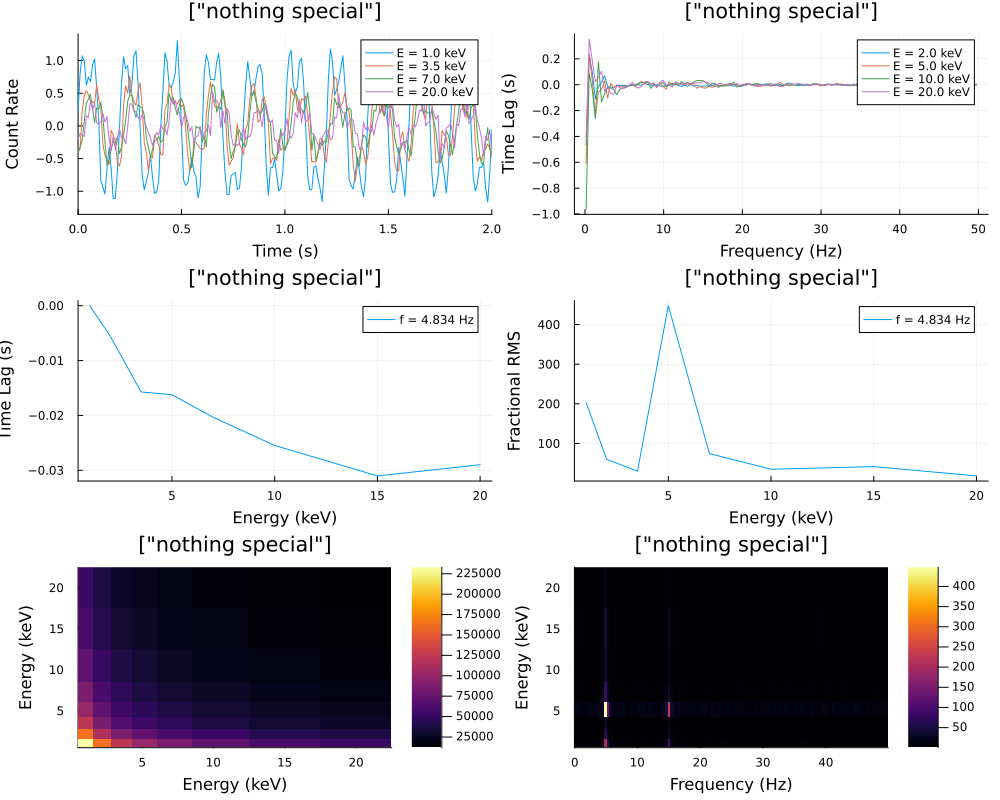

In [2]:
using FFTW
using LinearAlgebra
using Statistics
using Plots
using RecipesBase

# Abstract type for different kinds of signal data
abstract type AbstractSignal end

#========================================================
    BASIC TIME SERIES STRUCTURES
========================================================#

# Basic time series data structure
struct TimeSeries{T<:Real} <: AbstractSignal
    time::Vector{T}
    values::Vector{T}
    dt::T
    
    # Constructor with validation
    function TimeSeries(time::Vector{T}, values::Vector{T}) where T<:Real
        @assert length(time) == length(values) "Time and values vectors must have the same length"
        @assert issorted(time) "Time vector must be sorted"
        dt = length(time) > 1 ? time[2] - time[1] : zero(T)
        new{T}(time, values, dt)
    end
    
    # Constructor from values with uniform time steps
    function TimeSeries(values::Vector{T}, dt::T = 0.01) where T<:Real
        N = length(values)
        time = collect(range(0, step=dt, length=N))
        new{T}(time, values, dt)
    end
end

# Fourier transformed signal
struct FourierSignal{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    amplitudes::Vector{Complex{T}}
    dt::T
    N::Int
    
    # Constructor that validates input
    function FourierSignal(freqs::Vector{T}, amps::Vector{Complex{T}}, dt::T, N::Int) where T<:Real
        @assert length(freqs) == length(amps) "Frequencies and amplitudes must have the same length"
        new{T}(freqs, amps, dt, N)
    end
end

# Cross spectrum between two signals
struct CrossSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    values::Vector{Complex{T}}
    
    function CrossSpectrum(freqs::Vector{T}, vals::Vector{Complex{T}}) where T<:Real
        @assert length(freqs) == length(vals) "Frequencies and values must have the same length"
        new{T}(freqs, vals)
    end
end

# Power spectrum data
struct PowerSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    powers::Vector{T}
    
    function PowerSpectrum(freqs::Vector{T}, powers::Vector{T}) where T<:Real
        @assert length(freqs) == length(powers) "Frequencies and powers must have the same length"
        new{T}(freqs, powers)
    end
end

# Coherence data between two signals
struct CoherenceSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    coherence::Vector{T}
    time_lag::Vector{T}
    
    function CoherenceSpectrum(freqs::Vector{T}, coh::Vector{T}, lag::Vector{T}) where T<:Real
        @assert length(freqs) == length(coh) == length(lag) "All vectors must have the same length"
        new{T}(freqs, coh, lag)
    end
end

#========================================================
    ENERGY-DEPENDENT STRUCTURES
========================================================#

# Energy-dependent time series
struct EnergyTimeSeries{T<:Real} <: AbstractSignal
    time::Vector{T}
    values::Matrix{T}  # Dimensions: [time, energy_channel]
    energies::Vector{T}  # Center energy of each channel
    dt::T
    
    # Constructor with validation
    function EnergyTimeSeries(time::Vector{T}, values::Matrix{T}, energies::Vector{T}) where T<:Real
        @assert size(values, 1) == length(time) "Time dimension must match time vector length"
        @assert size(values, 2) == length(energies) "Energy dimension must match energies vector length"
        @assert issorted(time) "Time vector must be sorted"
        @assert issorted(energies) "Energy vector must be sorted"
        dt = length(time) > 1 ? time[2] - time[1] : zero(T)
        new{T}(time, values, energies, dt)
    end
end

# Energy-dependent Fourier transform
struct EnergyFourierSignal{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    amplitudes::Matrix{Complex{T}}  # Dimensions: [frequency, energy_channel]
    energies::Vector{T}
    dt::T
    N::Int
    
    function EnergyFourierSignal(freqs::Vector{T}, amps::Matrix{Complex{T}}, 
                                energies::Vector{T}, dt::T, N::Int) where T<:Real
        @assert size(amps, 1) == length(freqs) "Frequency dimension must match freqs vector length"
        @assert size(amps, 2) == length(energies) "Energy dimension must match energies vector length"
        new{T}(freqs, amps, energies, dt, N)
    end
end

# Covariance spectrum between energy channels
struct CovarianceSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T} 
    covariance::Array{Complex{T}, 3}  # Dimensions: [frequency, energy1, energy2]
    energies::Vector{T}
    
    function CovarianceSpectrum(freqs::Vector{T}, cov::Array{Complex{T}, 3}, energies::Vector{T}) where T<:Real
        @assert size(cov, 1) == length(freqs) "First dimension must match frequencies length"
        @assert size(cov, 2) == size(cov, 3) == length(energies) "Energy dimensions must match energies length"
        new{T}(freqs, cov, energies)
    end
end

# Energy-dependent time lags
struct EnergyLagSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    time_lags::Matrix{T}  # Dimensions: [frequency, energy_channel]
    energies::Vector{T}
    reference_energy::T
    
    function EnergyLagSpectrum(freqs::Vector{T}, lags::Matrix{T}, 
                              energies::Vector{T}, ref_energy::T) where T<:Real
        @assert size(lags, 1) == length(freqs) "Frequency dimension must match freqs vector length"
        @assert size(lags, 2) == length(energies) "Energy dimension must match energies vector length"
        new{T}(freqs, lags, energies, ref_energy)
    end
end

# RMS spectrum (frequency-dependent variability amplitude in each energy band)
struct RMSEnergySpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    rms::Matrix{T}  # Dimensions: [frequency, energy_channel]
    energies::Vector{T}
    
    function RMSEnergySpectrum(freqs::Vector{T}, rms::Matrix{T}, energies::Vector{T}) where T<:Real
        @assert size(rms, 1) == length(freqs) "Frequency dimension must match freqs vector length"
        @assert size(rms, 2) == length(energies) "Energy dimension must match energies vector length"
        new{T}(freqs, rms, energies)
    end
end

#========================================================
    BASIC TIME SERIES ANALYSIS FUNCTIONS
========================================================#

# Function to compute the Fourier transform of a time series
function fourier_transform(signal::TimeSeries{T}) where T<:Real
    N = length(signal.values)
    F = fft(signal.values)
    freq = fftfreq(N, 1.0/signal.dt)
    
    # Sort by frequency to ensure proper ordering
    idx = sortperm(freq)
    return FourierSignal(freq[idx], F[idx], signal.dt, N)
end

# Compute the cross spectrum of two light curves
function cross_spectrum(signal1::TimeSeries{T}, signal2::TimeSeries{T}) where T<:Real
    @assert length(signal1.values) == length(signal2.values) "Signals must have the same length"
    @assert signal1.dt ≈ signal2.dt "Signals must have the same time step"
    
    F1 = fourier_transform(signal1)
    F2 = fourier_transform(signal2)
    
    cross_values = F1.amplitudes .* conj.(F2.amplitudes)
    return CrossSpectrum(F1.frequencies, cross_values)
end

# Compute the cross spectrum from two Fourier signals
function cross_spectrum(f1::FourierSignal{T}, f2::FourierSignal{T}) where T<:Real
    @assert length(f1.amplitudes) == length(f2.amplitudes) "Fourier signals must have the same length"
    @assert f1.frequencies ≈ f2.frequencies "Frequency arrays must match"
    
    cross_values = f1.amplitudes .* conj.(f2.amplitudes)
    return CrossSpectrum(f1.frequencies, cross_values)
end

# Compute the power density spectrum (PDS) from a light curve
function power_spectrum(signal::TimeSeries{T}) where T<:Real
    F = fourier_transform(signal)
    powers = abs2.(F.amplitudes)
    return PowerSpectrum(F.frequencies, powers)
end

# Compute the power spectrum from a Fourier signal
function power_spectrum(fourier::FourierSignal{T}) where T<:Real
    powers = abs2.(fourier.amplitudes)
    return PowerSpectrum(fourier.frequencies, powers)
end

# Calculate the time lag from the cross spectrum
function time_lag(cs::CrossSpectrum{T}) where T<:Real
    phase_lag = angle.(cs.values)
    
    # Avoid division by zero at DC (zero frequency)
    lags = zeros(T, length(phase_lag))
    for i in eachindex(phase_lag)
        if abs(cs.frequencies[i]) > eps(T)
            lags[i] = phase_lag[i] / (2π * cs.frequencies[i])
        end
    end
    
    return lags
end

# Compute coherence from the cross spectrum and the individual power spectra
function coherence(cs::CrossSpectrum{T}, pds1::PowerSpectrum{T}, pds2::PowerSpectrum{T}) where T<:Real
    @assert length(cs.values) == length(pds1.powers) == length(pds2.powers) "All spectra must have the same length"
    @assert cs.frequencies ≈ pds1.frequencies ≈ pds2.frequencies "Frequency arrays must match"
    
    # Coherence is defined as |Cross Spectrum|^2 divided by the product of the power spectra
    coh_values = abs2.(cs.values) ./ (pds1.powers .* pds2.powers)
    lags = time_lag(cs)
    
    return CoherenceSpectrum(cs.frequencies, coh_values, lags)
end

# Function to get positive frequencies only (up to Nyquist)
function positive_frequencies(signal::AbstractSignal)
    if signal isa FourierSignal
        pos_idx = findall(signal.frequencies .>= 0)
        return FourierSignal(
            signal.frequencies[pos_idx],
            signal.amplitudes[pos_idx],
            signal.dt,
            signal.N
        )
    elseif signal isa CrossSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return CrossSpectrum(
            signal.frequencies[pos_idx],
            signal.values[pos_idx]
        )
    elseif signal isa PowerSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return PowerSpectrum(
            signal.frequencies[pos_idx],
            signal.powers[pos_idx]
        )
    elseif signal isa CoherenceSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return CoherenceSpectrum(
            signal.frequencies[pos_idx],
            signal.coherence[pos_idx],
            signal.time_lag[pos_idx]
        )
    end
    return signal  # Return original if not a frequency-domain signal
end

#========================================================
    ENERGY-DEPENDENT ANALYSIS FUNCTIONS
========================================================#

# Fourier transform across all energy channels
function fourier_transform(signal::EnergyTimeSeries{T}) where T<:Real
    N = length(signal.time)
    n_energies = length(signal.energies)
    
    # Prepare frequency array
    freq = fftfreq(N, 1.0/signal.dt)
    
    # Sort by frequency to ensure proper ordering
    idx = sortperm(freq)
    sorted_freq = freq[idx]
    
    # Compute FFT for each energy channel
    amplitudes = zeros(Complex{T}, length(sorted_freq), n_energies)
    
    for e in 1:n_energies
        F = fft(signal.values[:, e])
        amplitudes[:, e] = F[idx]
    end
    
    return EnergyFourierSignal(sorted_freq, amplitudes, signal.energies, signal.dt, N)
end

# Compute power spectra for all energy channels
function power_spectrum(signal::EnergyFourierSignal{T}) where T<:Real
    n_freq = length(signal.frequencies)
    n_energies = length(signal.energies)
    
    powers = zeros(T, n_freq, n_energies)
    for e in 1:n_energies
        powers[:, e] = abs2.(signal.amplitudes[:, e])
    end
    
    # Normalize power (uncomment for Leahy normalization)
    # powers = powers .* 2 ./ signal.N
    
    return powers
end

# Calculate covariance spectra between all energy channels
function covariance_spectrum(signal::EnergyFourierSignal{T}) where T<:Real
    n_freq = length(signal.frequencies)
    n_energies = length(signal.energies)
    
    # Create 3D array: [frequency, energy1, energy2]
    covariance = zeros(Complex{T}, n_freq, n_energies, n_energies)
    
    for i in 1:n_energies
        for j in 1:n_energies
            for f in 1:n_freq
                covariance[f, i, j] = signal.amplitudes[f, i] * conj(signal.amplitudes[f, j])
            end
        end
    end
    
    return CovarianceSpectrum(signal.frequencies, covariance, signal.energies)
end

# Calculate time lags relative to a reference energy channel
function time_lag_spectrum(signal::EnergyFourierSignal{T}, reference_idx::Int) where T<:Real
    n_freq = length(signal.frequencies)
    n_energies = length(signal.energies)
    
    time_lags = zeros(T, n_freq, n_energies)
    reference_energy = signal.energies[reference_idx]
    
    for e in 1:n_energies
        for f in 2:n_freq  # Skip DC (zero frequency)
            if abs(signal.frequencies[f]) > eps(T)
                # Calculate the phase difference
                phase = angle(signal.amplitudes[f, e] * conj(signal.amplitudes[f, reference_idx]))
                # Convert phase lag to time lag
                time_lags[f, e] = phase / (2π * signal.frequencies[f])
            end
        end
    end
    
    return EnergyLagSpectrum(signal.frequencies, time_lags, signal.energies, reference_energy)
end

# Calculate RMS variability amplitude as a function of energy and frequency
function rms_spectrum(signal::EnergyFourierSignal{T}) where T<:Real
    powers = power_spectrum(signal)
    n_freq = length(signal.frequencies)
    n_energies = length(signal.energies)
    
    # Calculate mean counts in each energy channel
    mean_counts = zeros(T, n_energies)
    for e in 1:n_energies
        # The DC component (f=0) represents the mean
        mean_counts[e] = abs(signal.amplitudes[1, e]) / signal.N
    end
    
    # Calculate fractional RMS in each frequency-energy bin
    rms = zeros(T, n_freq, n_energies)
    for e in 1:n_energies
        if mean_counts[e] > 0
            for f in 2:n_freq  # Skip DC
                # RMS = sqrt(Power) / Mean
                rms[f, e] = sqrt(powers[f, e]) / (mean_counts[e] * signal.N)
            end
        end
    end
    
    return RMSEnergySpectrum(signal.frequencies, rms, signal.energies)
end

# Function to bin frequency axis of any spectral data
function frequency_rebin(spectrum::AbstractSignal, rebin_factor::Int)
    if spectrum isa EnergyLagSpectrum
        n_freq = length(spectrum.frequencies)
        n_energies = length(spectrum.energies)
        
        # Calculate number of bins after rebinning
        n_bins = div(n_freq, rebin_factor)
        
        # Create new arrays
        new_freqs = zeros(eltype(spectrum.frequencies), n_bins)
        new_lags = zeros(eltype(spectrum.time_lags), n_bins, n_energies)
        
        # Perform rebinning
        for i in 1:n_bins
            idx_start = (i-1)*rebin_factor + 1
            idx_end = min(i*rebin_factor, n_freq)
            
            # Frequency is average of bin
            new_freqs[i] = mean(spectrum.frequencies[idx_start:idx_end])
            
            # Lags are averaged within bin
            for e in 1:n_energies
                new_lags[i, e] = mean(spectrum.time_lags[idx_start:idx_end, e])
            end
        end
        
        return EnergyLagSpectrum(new_freqs, new_lags, spectrum.energies, spectrum.reference_energy)
    
    elseif spectrum isa RMSEnergySpectrum
        # Similar implementation for RMSEnergySpectrum
        n_freq = length(spectrum.frequencies)
        n_energies = length(spectrum.energies)
        
        n_bins = div(n_freq, rebin_factor)
        
        new_freqs = zeros(eltype(spectrum.frequencies), n_bins)
        new_rms = zeros(eltype(spectrum.rms), n_bins, n_energies)
        
        for i in 1:n_bins
            idx_start = (i-1)*rebin_factor + 1
            idx_end = min(i*rebin_factor, n_freq)
            
            new_freqs[i] = mean(spectrum.frequencies[idx_start:idx_end])
            
            for e in 1:n_energies
                # RMS values should be averaged quadratically
                new_rms[i, e] = sqrt(mean(spectrum.rms[idx_start:idx_end, e].^2))
            end
        end
        
        return RMSEnergySpectrum(new_freqs, new_rms, spectrum.energies)
    elseif spectrum isa PowerSpectrum
        # Rebinning for regular power spectrum
        n_freq = length(spectrum.frequencies)
        n_bins = div(n_freq, rebin_factor)
        
        new_freqs = zeros(eltype(spectrum.frequencies), n_bins)
        new_powers = zeros(eltype(spectrum.powers), n_bins)
        
        for i in 1:n_bins
            idx_start = (i-1)*rebin_factor + 1
            idx_end = min(i*rebin_factor, n_freq)
            
            new_freqs[i] = mean(spectrum.frequencies[idx_start:idx_end])
            new_powers[i] = mean(spectrum.powers[idx_start:idx_end])
        end
        
        return PowerSpectrum(new_freqs, new_powers)
    end
    
    # Default case: return original
    return spectrum
end

# Function to create energy-dependent time series from a function
function generate_energy_dependent_signal(time_func::Function, energy_channels::Vector{T}, 
                                         time_range::Tuple{T,T}, dt::T, 
                                         noise_level::T=0.1) where T<:Real
    t = collect(time_range[1]:dt:time_range[2])
    n_times = length(t)
    n_energies = length(energy_channels)
    
    # Create matrix of values [time, energy]
    values = zeros(T, n_times, n_energies)
    
    for (e_idx, energy) in enumerate(energy_channels)
        # Generate signal dependent on time and energy
        for (t_idx, time) in enumerate(t)
            values[t_idx, e_idx] = time_func(time, energy) + noise_level * randn()
        end
    end
    
    return EnergyTimeSeries(t, values, energy_channels)
end

# Function to extract a single energy channel from EnergyTimeSeries
function extract_energy_channel(ets::EnergyTimeSeries{T}, energy_idx::Int) where T<:Real
    @assert 1 <= energy_idx <= length(ets.energies) "Energy index out of bounds"
    
    return TimeSeries(ets.time, ets.values[:, energy_idx])
end

# Function to extract a frequency band from energy-dependent spectra
function extract_frequency_band(spectrum::AbstractSignal, freq_range::Tuple{T,T}) where T<:Real
    if spectrum isa EnergyLagSpectrum
        idx = findall(freq_range[1] .<= spectrum.frequencies .<= freq_range[2])
        
        if isempty(idx)
            error("No frequencies found in the specified range")
        end
        
        return EnergyLagSpectrum(
            spectrum.frequencies[idx],
            spectrum.time_lags[idx, :],
            spectrum.energies,
            spectrum.reference_energy
        )
    elseif spectrum isa RMSEnergySpectrum
        idx = findall(freq_range[1] .<= spectrum.frequencies .<= freq_range[2])
        
        if isempty(idx)
            error("No frequencies found in the specified range")
        end
        
        return RMSEnergySpectrum(
            spectrum.frequencies[idx],
            spectrum.rms[idx, :],
            spectrum.energies
        )
    end
    
    return spectrum  # Return original if not supported
end

# Create frequency-averaged lag-energy and rms-energy spectra
function frequency_average(spectrum::AbstractSignal, freq_range::Tuple{T,T}) where T<:Real
    if spectrum isa EnergyLagSpectrum
        # Extract the frequency band
        band = extract_frequency_band(spectrum, freq_range)
        
        # Average lag across frequencies for each energy
        avg_lags = vec(mean(band.time_lags, dims=1))
        
        # Return averaged values
        return (band.energies, avg_lags)
    
    elseif spectrum isa RMSEnergySpectrum
        # Extract the frequency band
        band = extract_frequency_band(spectrum, freq_range)
        
        # Average RMS across frequencies for each energy (quadratic average)
        avg_rms = vec(sqrt.(mean(band.rms.^2, dims=1)))
        
        # Return averaged values
        return (band.energies, avg_rms)
    end
    
    return nothing  # Return nothing if not supported
end

#========================================================
    PLOTTING RECIPES - BASIC TIME SERIES
========================================================#
@recipe function f(ets::EnergyTimeSeries; energy_indices=nothing)
    title --> "Energy-Dependent Time Series"
    xlabel --> "Time (s)"
    ylabel --> "Count Rate"
    grid --> true
    
    # If specific energy indices are provided, only plot those
    if energy_indices === nothing
        energy_indices = 1:length(ets.energies)
    end
    
    # Plot multiple lines for each energy channel
    for (i, e_idx) in enumerate(energy_indices)
        @series begin
            label --> "E = $(round(ets.energies[e_idx], digits=2)) keV"
            ets.time, ets.values[:, e_idx]
        end
    end
end

# Recipe for energy-lag spectrum (lag vs energy at fixed frequency)
@recipe function f(els::EnergyLagSpectrum, ::Val{:energy_profile}; freq_idx=nothing)
    title --> "Time Lag vs Energy Profile"
    xlabel --> "Energy (keV)"
    ylabel --> "Time Lag (s)"
    grid --> true
    
    # If no specific frequency provided, use one near the middle
    if freq_idx === nothing
        # Find positive frequencies
        pos_freqs = findall(els.frequencies .> 0)
        freq_idx = pos_freqs[div(length(pos_freqs), 2)]
    end
    
    selected_freq = els.frequencies[freq_idx]
    
    @series begin
        label --> "f = $(round(selected_freq, digits=3)) Hz"
        els.energies, els.time_lags[freq_idx, :]
    end
end

# Recipe for RMS vs energy at specific frequency
@recipe function f(rms::RMSEnergySpectrum, ::Val{:energy_profile}; freq_idx=nothing)
    title --> "RMS Variability vs Energy"
    xlabel --> "Energy (keV)"
    ylabel --> "Fractional RMS"
    grid --> true
    
    # If no specific frequency provided, use one near the middle
    if freq_idx === nothing
        # Find positive frequencies
        pos_freqs = findall(rms.frequencies .> 0)
        freq_idx = pos_freqs[div(length(pos_freqs), 2)]
    end
    
    selected_freq = rms.frequencies[freq_idx]
    
    @series begin
        label --> "f = $(round(selected_freq, digits=3)) Hz"
        rms.energies, rms.rms[freq_idx, :]
    end
end

# Recipe for lag-frequency spectrum for multiple energy channels
@recipe function f(els::EnergyLagSpectrum; energy_indices=nothing, nyquist_only=true)
    title --> "Lag-Frequency Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Time Lag (s)"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(els.frequencies .>= 0)
        freqs = els.frequencies[idx]
    else
        freqs = els.frequencies
        idx = 1:length(freqs)
    end
    
    # If specific energy indices are provided, only plot those
    if energy_indices === nothing
        energy_indices = 1:length(els.energies)
    end
    
    # Plot multiple lines for each energy channel
    for (i, e_idx) in enumerate(energy_indices)
        @series begin
            label --> "E = $(round(els.energies[e_idx], digits=2)) keV"
            freqs, els.time_lags[idx, e_idx]
        end
    end
end

# Recipe for covariance spectrum heatmap
@recipe function f(cs::CovarianceSpectrum, ::Val{:heatmap}; freq_idx=nothing)
    title --> "Covariance Spectrum"
    xlabel --> "Energy (keV)"
    ylabel --> "Energy (keV)"
    
    # If no specific frequency provided, use one near the middle
    if freq_idx === nothing
        # Find positive frequencies
        pos_freqs = findall(cs.frequencies .> 0)
        freq_idx = pos_freqs[div(length(pos_freqs), 2)]
    end
    
    selected_freq = cs.frequencies[freq_idx]
    title --> "Covariance at f = $(round(selected_freq, digits=3)) Hz"
    
    # Extract magnitude for the selected frequency
    covariance_mag = abs.(cs.covariance[freq_idx, :, :])
    
    seriestype := :heatmap
    cs.energies, cs.energies, covariance_mag
end

# Recipe for energy-frequency RMS heatmap
@recipe function f(rms::RMSEnergySpectrum, ::Val{:heatmap}; nyquist_only=true)
    title --> "RMS Variability Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Energy (keV)"
    
    # Option to show only positive frequencies
    if nyquist_only
        idx = findall(rms.frequencies .>= 0)
        freqs = rms.frequencies[idx]
        rms_values = rms.rms[idx, :]
    else
        freqs = rms.frequencies
        rms_values = rms.rms
    end
    
    seriestype := :heatmap
    freqs, rms.energies, rms_values'  # Note the transpose to get the correct orientation
end

# ========================================================
# Example usage demonstrating the energy-dependent analysis

function energy_dependent_example()
    # Parameters
    N = 1024                    # number of time bins
    dt = 0.01                   # time resolution in seconds
    t = collect(0:dt:(N-1)*dt)  # time vector
    
    # Define energy channels (in keV)
    energies = [1.0, 2.0, 3.5, 5.0, 7.0, 10.0, 15.0, 20.0]
    n_energies = length(energies)
    
    # Define time-energy dependent signal function
    # Higher energy photons arrive with a delay relative to lower energy
    function example_signal(time, energy)
        f1 = 5.0  # Hz
        f2 = 15.0 # Hz
        
        # Energy-dependent amplitude (higher energies have lower amplitude)
        amplitude = 1.0 / sqrt(energy)
        
        # Energy-dependent time delay (higher energies lag)
        delay = 0.01 * log(energy)
        
        # Energy-dependent signal
        return amplitude * (sin(2π * f1 * (time - delay)) + 0.5 * sin(2π * f2 * (time - delay*1.5)))
    end
    
    # Generate energy-dependent time series
    ets = generate_energy_dependent_signal(example_signal, energies, (0.0, (N-1)*dt), dt, 0.1)
    
    # Plot energy-dependent time series (first 200 time points for clarity)
    p1 = plot(ets, xlims=(0, 2.0), energy_indices=[1, 3, 5, 8],title=["time_series"])
    
    # Compute Fourier transform for all energy channels
    efs = fourier_transform(ets)
    
    # Calculate RMS spectrum
    rms_spec = rms_spectrum(efs)
    
    # Calculate time lags relative to the first (lowest) energy channel
    lag_spec = time_lag_spectrum(efs, 1)
    
    # Calculate covariance spectrum
    cov_spec = covariance_spectrum(efs)
    
    # Rebin frequency to improve signal-to-noise
    rebinned_lag_spec = frequency_rebin(lag_spec, 4)
    rebinned_rms_spec = frequency_rebin(rms_spec, 4)
    
    # Plot lag-frequency spectrum for several energy channels
    p2 = plot(rebinned_lag_spec, energy_indices=[2, 4, 6, 8],title=["lag_frequency"])
    
    # Plot lag-energy profile at a specific frequency
    # Find a frequency index around 5 Hz
    freq_idx = findmin(abs.(rebinned_lag_spec.frequencies .- 5.0))[2]
    p3 = plot(rebinned_lag_spec, Val(:energy_profile), freq_idx=freq_idx,title=["lag_energy"])
    
    # Plot RMS-energy profile at a specific frequency
    p4 = plot(rebinned_rms_spec, Val(:energy_profile), freq_idx=freq_idx,title=["rms_energy"])
    
    # Plot covariance heatmap at a specific frequency
    # Find a frequency index around 5 Hz in the original (non-rebinned) data
    cov_freq_idx = findmin(abs.(cov_spec.frequencies .- 5.0))[2]
    p5 = plot(cov_spec, Val(:heatmap), freq_idx=cov_freq_idx,title=["covariance"])
    
    # Plot RMS heatmap (energy vs frequency)
    p6 = plot(rebinned_rms_spec, Val(:heatmap),title=["rms_map"])
    
    # Combine plots in a layout
    main_plot = plot(p1, p2, p3, p4, p5, p6, 
                  layout=(3,2), size=(1000, 800),
                  )
    
    return Dict(
        "time_series" => p1,
        "lag_frequency" => p2,
        "lag_energy" => p3,
        "rms_energy" => p4,
        "covariance" => p5,
        "rms_map" => p6,
        "main_layout" => main_plot
    )
end

# Run the energy-dependent example
energy_plots = energy_dependent_example()

# Display the main layout plot
display(energy_plots["main_layout"])